## Online Factorization Machine
Online factorization models take single data as an input, make a prediction, and train with the data. This notebook demonstrates fitting online models with an adam optimizer and those with hedge backpropagation (HBP) to criteo data.

### 1. Setup
The from models imports the package for use. We have also imported a few other packages for plotting.

In [ ]:
from utils import data_preprocess, plot
import os
import pickle
import numpy as np
import torch

import sys
from time import time

from models.models_online_deep.deepfm_adam import DeepFMAdam
from models.models_online_deep.deepfm_onn import DeepFMOnn
from models.models_online_deep.nfm_adam import NFMAdam
from models.models_online_deep.nfm_onn import NFMOnn
from models.models_online_deep.fm_adam import FMAdam

from models.models_online_deep.afm_adam import AFMAdam

In [18]:
save_log = os.getcwd() + '/../performance/save_log/'
save_model = os.getcwd() + '/../performance/save_model/'

if not os.isdir(save_log):
    os.makedir(save_log)
if not os.isdir(save_model):
    os.makedir(save_model)

### 2. Create a criteo dataset
A dataset for a factorization machine requires indices, values, and labels. 

In [19]:
train_dict = data_preprocess.read_criteo_data('../dataset/criteo/tiny_train_input.csv', 
                                              '../dataset/criteo/category_emb.csv')
train_dict_size = train_dict['size']

In [20]:
num_batchdata = 2500
num_batch = 10
data_config = 7
# data_config = 3

if data_config == "Iteration":
    batch_train_Xi_list, batch_train_Xv_list, batch_train_Y_list, ratio_list \
        = data_preprocess.create_ten_iter('../dataset/criteo/tiny_train_input.csv', '../dataset/criteo/category_emb.csv', num_batch, num_batchdata)

elif isinstance(data_config, int):
    batch_train_Xi_list, batch_train_Xv_list, batch_train_Y_list, ratio_list \
        = data_preprocess.create_dataset('../dataset/criteo/tiny_train_input.csv', '../dataset/criteo/category_emb.csv', data_config, num_batch, num_batchdata)

else:
    batch_train_Xi_list, batch_train_Xv_list, batch_train_Y_list, ratio_list \
        = data_preprocess.create_dataset('../dataset/criteo/tiny_train_input.csv', '../dataset/criteo/category_emb.csv', int(num_batch/2), num_batch, num_batchdata)

In [21]:
num_hidden_layers = 5
neuron_per_hidden_layer = 10
data_feature_dim = 39
embedding_size = 10
n = 0.0001

feature_sizes = [63, 113, 126, 51, 224, 148, 100, 79, 104, 9, 32, 57, 82, 1457, 555, 176373, 129683, 305, 19, 11887,
                 632, 3, 41738, 5170, 175446, 3170, 27, 11356, 165602, 10, 4641, 2030, 4, 172761, 18, 15, 57903, 86,
                 44549]
# num_feature = sum(feature_sizes)

### 3. Create online factorization machines
There are five models in this notebook: DeepFM, NFM with both an adam optimizer and HB, and FM with an adam optimizer. Treatments for each models are referenced from [PyTorch Implementations of Factorization Machines](https://github.com/nzc/dnn_ctr).

In [22]:
model_list = [
    NFMAdam(feature_sizes,
            embedding_size=embedding_size,
            num_hidden_layers=num_hidden_layers,
            neuron_per_hidden_layer=neuron_per_hidden_layer,
            n=n),
    NFMOnn(feature_sizes,
           embedding_size=embedding_size,
           num_hidden_layers=num_hidden_layers,
           neuron_per_hidden_layer=neuron_per_hidden_layer,
           n=n),
    DeepFMAdam(feature_sizes,
               embedding_size=embedding_size,
               num_hidden_layers=num_hidden_layers,
               neuron_per_hidden_layer=neuron_per_hidden_layer,
               n=n),
    DeepFMOnn(feature_sizes,
              embedding_size=embedding_size,
              num_hidden_layers=num_hidden_layers,
              neuron_per_hidden_layer=neuron_per_hidden_layer,
              n=n),
    FMAdam(feature_sizes,
           embedding_size=embedding_size,
           n=n)
]

In [23]:
model_name_list = [str(model).split('-')[0] for model in model_list]
print(model_name_list)

['NFMAdam', 'NFMOnn', 'DeepFMAdam', 'DeepFMOnn', 'FMAdam']


### 4. Pretrain the models
Models are pretrained with a batch of data from a dataset made above.

In [24]:
for ith_model, ith_model_name in zip(model_list, model_name_list):
    print(f"====={ith_model_name}=====")
    for j in range(1000):
        loss_emb = ith_model.update_embedding(batch_train_Xi_list[int(num_batch/2)],
                                              batch_train_Xv_list[int(num_batch/2)],
                                              batch_train_Y_list[int(num_batch/2)])
        pred_label = ith_model.predict(batch_train_Xi_list[int(num_batch/2)],
                                       batch_train_Xv_list[int(num_batch/2)])

        if j % 100 == 0:
            print('i th iter %d , loss : %f' % (j, loss_emb.cpu().data))
            right_count = len((np.where(np.asarray(pred_label) == np.asarray(batch_train_Y_list[int(num_batch/2)])))[0])
            total_count = len(np.asarray(batch_train_Y_list[int(num_batch/2)]))
            print('training accuracy : %.4f\n' % (right_count / total_count))

=====NFMAdam=====
i th iter 0 , loss : 0.657433
training accuracy : 0.5656

i th iter 100 , loss : 0.642589
training accuracy : 0.5700

i th iter 200 , loss : 0.638788
training accuracy : 0.5752

i th iter 300 , loss : 0.635720
training accuracy : 0.5788

i th iter 400 , loss : 0.632254
training accuracy : 0.5872

i th iter 500 , loss : 0.628087
training accuracy : 0.5936

i th iter 600 , loss : 0.623049
training accuracy : 0.5988

i th iter 700 , loss : 0.619863
training accuracy : 0.6080

i th iter 800 , loss : 0.615999
training accuracy : 0.6128

i th iter 900 , loss : 0.611864
training accuracy : 0.6176

=====NFMOnn=====
i th iter 0 , loss : 0.671129
training accuracy : 0.7000

i th iter 100 , loss : 0.657251
training accuracy : 0.7000

i th iter 200 , loss : 0.652255
training accuracy : 0.7000

i th iter 300 , loss : 0.649267
training accuracy : 0.7000

i th iter 400 , loss : 0.647342
training accuracy : 0.7000

i th iter 500 , loss : 0.644631
training accuracy : 0.7000

i th iter

### 5. Fit models to the whole dataset
After creating instances of models and pretraining them, we have to fit models to the whole online dataset.

In [25]:
result_dict = {}
result_dict['roc'] = {}
result_dict['data_ratio'] = {}
result_dict['time'] = {}
result_dict['accuracy'] = {}

result_dict['num_batch'] = num_batch
result_dict['num_batchdata'] = num_batchdata
result_dict['user_auc_mean'] = {}

In [26]:
for ith_exp in range(num_batch):
    print('#' * 100)

    for jth_model_name, jth_model in zip(model_name_list, model_list):
        print('%d th batch, %s model' % (ith_exp + 1, jth_model_name))
        print('neg ratio : %d,  pos ratio %d ' % (ratio_list[ith_exp][0], ratio_list[ith_exp][1]))

        time_elapsed, accuracy, roc, confusion_matrix\
            = jth_model.run_experiment(batch_train_Xi_list[ith_exp], batch_train_Xv_list[ith_exp], batch_train_Y_list[ith_exp])

        print('fpr : %.4f , tpr : %.4f ' % (roc['fpr'], roc['tpr']))
        print('confusion matrix : %s' % confusion_matrix)
        print('accuracy : %.4f \n' % accuracy)

        if ith_exp == 0:
            result_dict['roc'][jth_model_name] = [roc]
            result_dict['data_ratio'][jth_model_name] = [ratio_list[ith_exp]]
            result_dict['time'][jth_model_name] = [time_elapsed]
            result_dict['accuracy'][jth_model_name] = [accuracy]

        else:
            result_dict['roc'][jth_model_name].append(roc)
            result_dict['data_ratio'][jth_model_name].append(ratio_list[ith_exp])
            result_dict['time'][jth_model_name].append(time_elapsed)
            result_dict['accuracy'][jth_model_name].append(accuracy)

####################################################################################################
1 th batch, NFMAdam model
neg ratio : 7,  pos ratio 3 
fpr : 0.9173 , tpr : 0.9320 
confusion matrix : {'tp': 1631, 'fp': 688, 'tn': 62, 'fn': 119}
accuracy : 67.7200 

1 th batch, NFMOnn model
neg ratio : 7,  pos ratio 3 
fpr : 1.0000 , tpr : 1.0000 
confusion matrix : {'tp': 1750, 'fp': 750, 'tn': 0, 'fn': 0}
accuracy : 70.0000 

1 th batch, DeepFMAdam model
neg ratio : 7,  pos ratio 3 
fpr : 0.5373 , tpr : 0.5640 
confusion matrix : {'tp': 987, 'fp': 403, 'tn': 347, 'fn': 763}
accuracy : 53.3600 

1 th batch, DeepFMOnn model
neg ratio : 7,  pos ratio 3 
fpr : 0.6053 , tpr : 0.6286 
confusion matrix : {'tp': 1100, 'fp': 454, 'tn': 296, 'fn': 650}
accuracy : 55.8400 

1 th batch, FMAdam model
neg ratio : 7,  pos ratio 3 
fpr : 0.5653 , tpr : 0.5714 
confusion matrix : {'tp': 1000, 'fp': 424, 'tn': 326, 'fn': 750}
accuracy : 53.0400 

####################################################

fpr : 0.8680 , tpr : 0.8909 
confusion matrix : {'tp': 1559, 'fp': 651, 'tn': 99, 'fn': 191}
accuracy : 66.3200 

9 th batch, FMAdam model
neg ratio : 7,  pos ratio 3 
fpr : 0.5707 , tpr : 0.6697 
confusion matrix : {'tp': 1172, 'fp': 428, 'tn': 322, 'fn': 578}
accuracy : 59.7600 

####################################################################################################
10 th batch, NFMAdam model
neg ratio : 7,  pos ratio 3 
fpr : 0.9947 , tpr : 0.9949 
confusion matrix : {'tp': 1741, 'fp': 746, 'tn': 4, 'fn': 9}
accuracy : 69.8000 

10 th batch, NFMOnn model
neg ratio : 7,  pos ratio 3 
fpr : 1.0000 , tpr : 0.9994 
confusion matrix : {'tp': 1749, 'fp': 750, 'tn': 0, 'fn': 1}
accuracy : 69.9600 

10 th batch, DeepFMAdam model
neg ratio : 7,  pos ratio 3 
fpr : 0.5693 , tpr : 0.6469 
confusion matrix : {'tp': 1132, 'fp': 427, 'tn': 323, 'fn': 618}
accuracy : 58.2000 

10 th batch, DeepFMOnn model
neg ratio : 7,  pos ratio 3 
fpr : 1.0000 , tpr : 0.9983 
confusion matrix : {'t

### 6. Save models
When the training is done, models are saved to a designated directory as pickle files. Their ROC scores, accuracy scores, and amount of time required are also saved.

In [28]:
save_filename = 'Time_Stamp' + str(int(time()))\
                + '-Dataset' + str('criteo') \
                + '-Num_BatchLength' + str(num_batchdata) \
                + '-Num_Batch' + str(num_batch) \
                + '-Num_Hidden_Layers' + str(num_hidden_layers) \
                + '-Neuron_Per_Hidden_Layer' + str(neuron_per_hidden_layer) \
                + '_' + str(data_config)

with open(save_log + save_filename + '.pickle', 'wb') as f:
    pickle.dump(result_dict, f)

for ith_model, ith_model_name in zip(model_list, model_name_list):
    with open(save_model + str(ith_model_name) + '.pickle', 'wb') as f:
        pickle.dump(ith_model, f)

print('save_log: %s' % (save_log + save_filename + '.pickle'))
print('save_model: %s' % save_model)

save_log : /home/yeji/Myenv/research/SILAB-Online-Recommendation/performance/save_log/Time_Stamp1578375578-Datasetcriteo-Num_BatchLength2500-Num_Batch10-Num_Hidden_Layers5-Neuron_Per_Hidden_Layer10_7.pickle
save_model : /home/yeji/Myenv/research/SILAB-Online-Recommendation/performance/save_model/


### 7. Plot graphs
We are able to draw ROC curves and accuracy score graphs according to the models' performance. For the ROC curve, the x-axis indicates false positive rates (FPR or (1-specificity)) and the y-axis indicates true positive rates (TPR or sensitivity). The x-axis and the y-axis in the accuracy score graph indicates the sequence of iteration and number of correct answers that the model has made. 

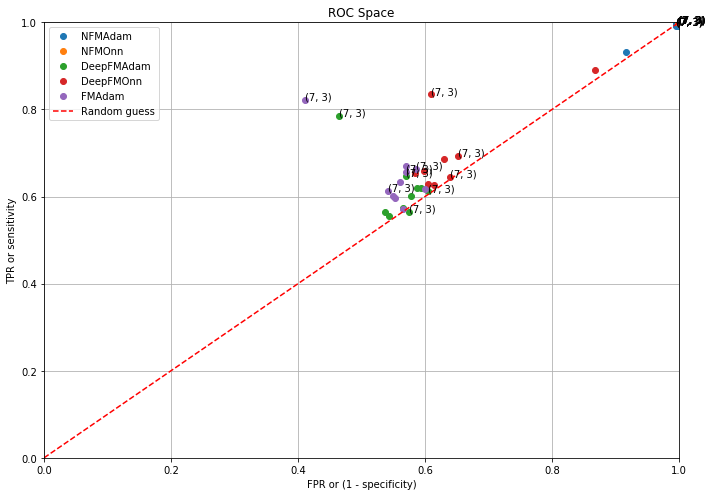

In [2]:
plot.draw_roc_graph(save_log, save_filename + '.pickle')

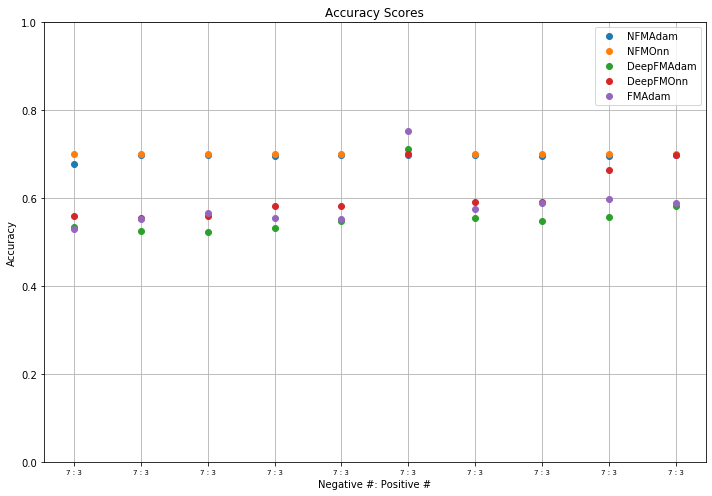

In [3]:
plot.draw_roc_graph(save_log, save_filename + '.pickle')